### This analysis investigates the association between shift work and the incidence of Gastroesophageal Reflux Disease (GERD) among the nursing staff at Rabin Medical Center.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
import seaborn as sns
import math
import datetime as dt
import statsmodels
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.discrete.conditional_models import ConditionalLogit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import product
import statsmodels.api as sm
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene, chisquare, chi2_contingency, wilcoxon
import warnings
import random
warnings.filterwarnings('ignore')

### Fetch data

The data for this study is based on two main sources:
- Personal health records: Personal health records were obtained from Clalit, the largest health maintenance organization in Israel, where the study population is registered. The personal health records will include key patient characteristics such as age, sex, BMI in each year, country of origin, Charlson Comorbidity Index, medication purchased and licensed in each year, as well as diagnosis information. The diagnosis information consists of two attributes - type of diagnosis and date of diagnosis, and is available at one or two sample times - prior to start of work at Clalit, and after start of work at Clalit.

- Employee shift work records: Employee shift work records were obtained from Rabin Medical Center. These records will include the amount of morning, evening, and night shifts that each nurse worked on each month during the study period, from 2015 to 2020.




In [2]:
path = r"\\10.100.117.3\Projects\R04-Belinson\R04-GERD_Ramd\Yoav\\"

#health records data
df_health = pd.read_csv(path+"national DATA Gred 18-5-23.csv", 
                 parse_dates=['ESOPHAGITIS after-Start date', 'Birth date', 'BMI BL-Measurement date'])

#Employee shift work data
shifts_data = pd.read_excel(path+'פירוט כל המשמרות לפי חודשים.xlsx', 
                     parse_dates=['employment_start_date'])


### Remove patients that were diagnosed prior to starting to work

In [3]:
# if the diagsnosis date is before 2015 we can't find correlation to the shifts data
mask = df_health[df_health['ESOPHAGITIS after-Start date'] < datetime.datetime(2015,1,1)].index
df_health = df_health.drop(mask)
df_health['first_sign_of_ESO'] = df_health['ESOPHAGITIS after-Start date']
#Patients that were diagnosed
df_health['first_sign_of_ESO'].value_counts().sum()

200

### Calculation of Shift Work

Estimate the severity of the median amount of shifts performed by each nurse in the time of exposure, 12 month before being diagnosed or if the nurse wasn’t diagnosed we will use it’s matched partner diagnosed date. 

In [4]:
#create index for month and year as a continuous integer variable
def get_index_month_year(row):
    year_count = int(row['year']) - 2015
    return year_count*12 + row['month']

shifts_data['index_month_year'] = shifts_data.apply(lambda row: get_index_month_year(row), axis=1)

In [5]:
#get relevant columns for shift analysis
cols = ['InternalPatientID', 'night', 'evening', 'morning', 'index_month_year', 'year', 'month','employment_start_date']
shifts_data = shifts_data[cols]

#remove NaN values and put zero instead - since NaN means 0 shifts of this type
shifts_data.fillna(0, inplace=True)

In [6]:
# get nurses that worked at least 2 month over the years, otherwise consider as not worked
temp = pd.DataFrame(shifts_data.groupby(['InternalPatientID'])['index_month_year'].count())
mask = temp[temp['index_month_year']>2].index
shifts_data = shifts_data[shifts_data['InternalPatientID'].isin(mask)]

In [7]:
#calculate the number of months with nights and the median number of nights for each patient
shifts_patient = shifts_data.groupby(['InternalPatientID'], as_index=False).agg(
    count_month_w_nights = ('night', lambda x: sum(x>0)),
    median_nights = ('night', lambda x: x.quantile(0.5)),
)

In [8]:
#define the most "severe" number of nights per patients by percentiles (upper 90 percentile and lower 10 percentile)
quantile_9 = shifts_patient['median_nights'].quantile(0.9)
quantile_1 = shifts_patient['median_nights'].quantile(0.1)
quantile_1, quantile_9

(0.0, 6.0)

In [9]:
#calculate in which exposure group each patient is, based on their median number of nights
def get_expose_group(row):
    if row['median_nights']>=quantile_9:
        return 'exposed'
    elif row['median_nights']<=quantile_1:
        return 'unexposed'
    else: 
        return None

shifts_patient['expose_group'] = shifts_patient.apply(lambda row: get_expose_group(row), axis=1)
shifts_patient['expose_group'].value_counts()

unexposed    1755
exposed       391
Name: expose_group, dtype: int64

## Merge Shift data with health records

In [10]:
# add employment start date from shift data to health records
df = df_health.merge(shifts_data[['InternalPatientID', 'employment_start_date']].groupby('InternalPatientID').min(), 
         left_on='Patient ID', right_on='InternalPatientID', how = 'left')
df['employment_start_date'] = pd.to_datetime(df['employment_start_date'])

In [11]:
# merge data and shifts data
df = df.merge(shifts_patient, left_on='Patient ID', right_on='InternalPatientID', how = 'inner')
df.shape

(2476, 144)

## Preprocess variables

In [12]:
#add a variable specifying if the patient was diagnosed
df['is_ill'] = ~df['first_sign_of_ESO'].isna()
df['is_ill'].value_counts()

False    2279
True      197
Name: is_ill, dtype: int64

In [13]:
#create a categorial variable indicating illness
df['is_ill_cat'] = df.apply(lambda x: "diagnosed with GERD" if x['is_ill'] else "not diagnosed", axis=1)
df['is_ill_cat'].value_counts()

not diagnosed          2279
diagnosed with GERD     197
Name: is_ill_cat, dtype: int64

### Age variables

- Age at 2015 - the reference date for calculating the age is 1/1/2015 as this is a time point where we started to collect data on their work lifestyle.
- Age at diagnosis of GERD - for subjects not diagnosed this variable is null.

In [14]:
#calculate the age at 2015 which is the beginning of the staudy
df['age_2015'] = df['Birth date'].apply(lambda x: (dt.datetime(2015, 1, 1)- x)/dt.timedelta(days=365))
df = df[df['age_2015']<70].copy()

#calculate the age at diagnosis by the field of first ESO sign
df.rename(columns={'ESOPHAGITIS after-Age at diagnosis':'age_at_diagnosis'}, inplace=True)

### BMI variables

- BMI at diagnosis of GERD - We defined this BMI field to be the closest BMI value recorded before a patient's GERD diagnosis, or the most recent BMI measurement if the patient has never been diagnosed. 
- BMI before starting to work -  This field is defined as the closest BMI value recorded before beginning of work at Clalit.


In [15]:
# remove BMI values that are typo - do not make sense based on BMI definition
df['BMI BL-BMI'] = df['BMI BL-BMI'].apply(lambda x: x if x>10 and x<50 else None)
cols = df.columns[df.columns.str.match('^BMI \d{4}-BMI$')].tolist() + ['BMI last-BMI']
for col in cols:
    df[col] = df[col].apply(lambda row: row if row>10 and row<50 else None)

In [16]:
# Calculate BMI before diagnosed
date_cols = df.columns[df.columns.str.match('^BMI .*-Measurement date$')].tolist()
cols = df.columns[df.columns.str.match('^BMI.*-BMI$')].tolist()
df['BMI date before diag'] = ''
df['BMI value before diag'] = ''

for col in date_cols:
    df[col] = pd.to_datetime(df[col])

cnt_1 = 0
for index, row in df.iterrows():
    beore_dig_dates = []
    if pd.notna(row['BMI last-Measurement date']):
        for col in date_cols:
            if row[col] < max(row['employment_start_date'], row['first_sign_of_ESO']):
                beore_dig_dates.append(row[col])
    if beore_dig_dates:       
        # out of all the dates before he got diagnosed or started to work
        df.at[index, 'BMI date before diag'] = max(beore_dig_dates)
        # find the BMI with the corresponsding date
        df.at[index, 'BMI value before diag'] = row[cols[beore_dig_dates.index(max(beore_dig_dates))]]
    else:
        df.at[index, 'BMI date before diag'] = row['BMI last-Measurement date']
        df.at[index, 'BMI value before diag'] = row['BMI last-BMI']

In [17]:
# Calculate BMI before start of work
df['BMI_date_before_start_work'] = ''
df['BMI_value_before_start_work'] = ''

for col in date_cols:
    df[col] = pd.to_datetime(df[col])

cnt_1 = 0
for index, row in df.iterrows():
    beore_dig_dates = []
    if pd.notna(row['BMI last-Measurement date']):
        for col in date_cols:
            if row[col] < row['employment_start_date']:
                beore_dig_dates.append(row[col])
    if beore_dig_dates:       
        # out of all the dates before he got diagnosed or started to work
        df.at[index, 'BMI_date_before_start_work'] = max(beore_dig_dates)
        # find the BMI with the corresponsding date
        df.at[index, 'BMI_value_before_start_work'] = row[cols[beore_dig_dates.index(max(beore_dig_dates))]]
    else:
        df.at[index, 'BMI_date_before_start_work'] = row['BMI last-Measurement date']
        df.at[index, 'BMI_value_before_start_work'] = row['BMI last-BMI']

### Socio-economic score variable

Socio economic score has 5 level scale, the higher value defining higher socio-economic status. The index is calculated on the basis of demographic data, standard of living, distribution of grants to local authorities (mainly balance grants). Education and training, employment, unemployment and pensions. The municipalities and local councils were classified according to the index values into clusters, when lower clusters indicate lower socio-economic level.

In [18]:
order_5 = {'Very Low':0, 'Low':1, 'Medium':2, 'High':3, 'Very High':4, None:-1, 'no data': -1}
df['Socioeconomic score five level scale int']= df['Socioeconomic score five level scale'].apply(lambda x: order_5[x])

### Charlson Cormobidity Index Variable

The Charlson comorbidity index predicts the ten-year mortality for a patient who may have a range of comorbid conditions, such as heart disease, AIDS, or cancer. Each condition is assigned a score of 1, 2, 3, or 6, depending on the risk of mortality associated with it.

This score is defined as the last score prior to diagnosis of GERD, and if there was no diagnosis the last score available in the dataset.


In [19]:
#Take the last charlson measurment that is prior to diagnosis, and if the patient was not diagnosed the last measurement of charlson.
def get_max_charlson_prior_diagnose(row):
    diagnose_date = row['first_sign_of_ESO']
    if pd.isnull(diagnose_date): #if not diagnoes take last
        return row['charlsocn last-Event Date'], row['charlsocn last-Charlson Score Total']
    
    if row['charlsocn last-Event Date'] < diagnose_date:
        return row['charlsocn last-Event Date'], row['charlsocn last-Charlson Score Total']
    
    if row['charlsocn BL-Event Date'] < row['charlsocn 2015-Event Date']:
        if row['charlsocn 2015-Event Date'] < diagnose_date:
            return row['charlsocn 2015-Event Date'], row['charlsocn 2015-Charlson Score Total'] 
        elif row['charlsocn BL-Event Date'] < diagnose_date:
            return row['charlsocn BL-Event Date'], row['charlsocn BL-Charlson Score Total']
    elif row['charlsocn BL-Event Date'] < diagnose_date:
            return row['charlsocn BL-Event Date'], row['charlsocn BL-Charlson Score Total']
    elif row['charlsocn 2015-Event Date'] < diagnose_date:
            return row['charlsocn 2015-Event Date'], row['charlsocn 2015-Charlson Score Total'] 
    return None, None

In [20]:
df['charlsocn last-Event Date'] = pd.to_datetime(df['charlsocn last-Event Date'])
df['charlsocn 2015-Event Date'] = pd.to_datetime(df['charlsocn 2015-Event Date'])
df['charlsocn BL-Event Date'] = pd.to_datetime(df['charlsocn BL-Event Date'])
df['max_charlson_prior_diagnose'] = df.apply(lambda row: get_max_charlson_prior_diagnose(row), axis=1) #these are tuples of date and value
df['max_charlson_prior_diagnose_date'] = df.apply(lambda row: row['max_charlson_prior_diagnose'][0], axis=1)
df['max_charlson_prior_diagnose_value'] = df.apply(lambda row: row['max_charlson_prior_diagnose'][1], axis=1)

### Smoke correction

This is a categorical variable, constructed from three smoking types - “never”, “in the past” and “currently”. The smoking status is extracted as the last status prior diagnosis of GERD, if the subject was diagnosed. Otherwise, it is the last status available. Less than 10% of values were null.


In [21]:
# convert smoking variable from hebrew to int
def smoke_to_int(smoke):
    if smoke is None:
        return None
    if smoke=='מעולם לא':
        return 0
    if smoke=='בעבר':
        return 1
    if str(smoke).startswith('כעת'):
        return 2
df['smoking BL-categorial'] = df.apply(lambda x: smoke_to_int(x['smoking BL-Smoking status']), axis=1)
df['smoking last-categorial'] = df.apply(lambda x: smoke_to_int(x['smoking last-Smoking status']), axis=1)

In [22]:
#get the maximum smoking status prior diagnosis
def get_max_smoke_prior_diagnose(row):
    diagnose_date = row['first_sign_of_ESO']
    if pd.isnull(diagnose_date): #if not diagnoes take last
        return row['smoking last-Measurement date'], row['smoking last-categorial']
    
    if row['smoking last-Measurement date'] < diagnose_date:
        return row['smoking last-Measurement date'], row['smoking last-categorial']
    
    else:
        return row['smoking BL-Measurement date'], row['smoking BL-categorial']
    return None, None

date_cols = ['smoking last-Measurement date', 'smoking BL-Measurement date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])
    
df['max_smoke_prior_diagnose'] = df.apply(lambda row: get_max_smoke_prior_diagnose(row), axis=1) #these are tuples of date and value
df['max_smoke_prior_diagnose_date'] = df.apply(lambda row: row['max_smoke_prior_diagnose'][0], axis=1)
df['max_smoke_prior_diagnose_value'] = df.apply(lambda row: row['max_smoke_prior_diagnose'][1], axis=1)

In [23]:
#get a categorial variable of smoke status in english for the plots
def smoke_to_cat_2(smoke):
    if smoke is None:
        return None
    if smoke==0:
        return "never"
    if smoke==1:
        return "in the past"
    if smoke==2:
        return "currently"
df['max_smoke_prior_diagnose_value_eng'] = df.apply(lambda x: smoke_to_cat_2(x['max_smoke_prior_diagnose_value']), axis=1)

In [24]:
#change the Cat var of country to englush for the plots
def transalte_country(df, column):
    # Define a mapping from Hebrew to English.
    translation_dict = {
        'ישראל': 'Israel',
        'ארצות הברית': 'United States',
        'צרפת': 'France',
        'בריטניה': 'United Kingdom',
        'רוסיה': 'Russia',
        'ברית המועצות': 'Soviet Union',
        'גרמניה': 'Germany',
        'איטליה': 'Italy',
        'ספרד': 'Spain',
        'ברזיל': 'Brazil',
        'מקסיקו': 'Mexico',
        'קנדה': 'Canada',
        'הודו': 'India',
        'אוסטרליה': 'Australia',
        'ארגנטינה': 'Argentina',
        'סין': 'China',
        'אפגניסטן': 'Afghanistan',
        'אלגריה': 'Algeria',
        'בחרין': 'Bahrain',
        'מצרים': 'Egypt',
        'עיראק': 'Iraq',
        'לבנון': 'Lebanon',
        'לוב': 'Libya',
        'מרוקו': 'Morocco',
        'פלסטין': 'Palestine',
        'קטר': 'Qatar',
        'סוריה': 'Syria',
        'טוניסיה': 'Tunisia',
        'אתיופיה': 'Ethiopia',
        'אוקראינה': 'Ukraine',
        'רומניה': 'Romania',
        'אירן': 'Iran',
        'אוזבקיסטאן': 'Uzbekistan'
    }

    # Use the map method to replace each Hebrew name with the English name.
    df[column] = df[column].map(translation_dict)

    # If any country was not found in the dictionary, fill it with 'Unknown'.
    df[column] = df[column].fillna('Unknown')

    return df

df = transalte_country(df,'Country of birth')
df['Country of birth'].value_counts()

Israel           1534
Soviet Union      354
Ethiopia          129
Ukraine           116
Unknown           104
Russia             92
Morocco            43
Romania            23
Iran               18
Uzbekistan         15
United States      13
Argentina           6
India               5
Germany             3
Egypt               3
Brazil              2
Australia           2
Libya               2
Afghanistan         1
Canada              1
Syria               1
France              1
Spain               1
Name: Country of birth, dtype: int64

## Matching Process and Statistical Analysis

The matching approach utilizes specific covariates recognized to have potential influence on the diagnosis of GERD. We will carry a pairwise matching between diagnosed and undiagnosed nurses, using the following covariates: gender, age, BMI, smoking, socioeconomic status and Charlson Comorbidity Index.

### Preprocessing values for matching

In [25]:
#define the variables to use for matching
df['female'] = df['Gender'].replace(['Male', 'Female'], [0, 1]).astype('int')

df['age_2015'] = df['age_2015'].astype('float64')

df['is_ill2'] = df['is_ill'].astype(int)

df['max_smoke_prior_diagnose_value'].fillna(-1, inplace=True)

# add average BMI value for those who did not have value for BMI
df['BMI_missing'] = df['BMI_value_before_start_work'].apply(lambda x: 1 if pd.isna(x) else 0)
df['BMI_value_before_start_work'].fillna(df['BMI_value_before_start_work'].mean(), inplace=True)
df['BMI_value_before_start_work'] = df['BMI_value_before_start_work'].astype('float64')

In [26]:
#rename covariates with shorter names for easier matching
df_matching =  df.rename(columns={"Socioeconomic score five level scale int": "socio", "max_smoke_prior_diagnose_value": "smoke", 'age_2015':"age",'BMI_value_before_start_work':"BMI", 'charlsocn BL-Charlson Score Total':'charlson','Country of birth':'Country' }, inplace=False)

df_matching['is_ill'].value_counts()

False    2274
True      195
Name: is_ill, dtype: int64

In [27]:
#get indices of patients to apply matching
X_to_pID = df_matching['Patient ID'].to_dict()

### Remove subjects with missing shift data before matching

In [28]:
#create index for month year 
def get_index_month_year_ill(date):
    year_count = date.year - 2015
    return year_count*12 + date.month

In [29]:
#remove ill patients that did not work in the year prior to diagnosis (ill group)
temp = df_matching.copy()
temp['ref_date_index'] = temp['first_sign_of_ESO'].apply(lambda x: get_index_month_year_ill(x))
temp = shifts_data.merge(temp, on='InternalPatientID', how='left')
temp_ill = temp[(temp['index_month_year']<=temp['ref_date_index']) & (temp['index_month_year']>=temp['ref_date_index']-12)]
patients = temp_ill['InternalPatientID'].unique()
df_matching_ill = df_matching[df_matching['InternalPatientID'].isin(patients)]

# remove those who worked less than 5 years out of 6 (non ill group)
temp_nill = temp[pd.isna(temp['ref_date_index'])]
temp_nill = temp_nill.groupby('InternalPatientID')['InternalPatientID'].count()
df_matching_nill = df_matching[df_matching['InternalPatientID'].isin(temp_nill[temp_nill>60].index)]

df_matching = pd.concat([df_matching_ill, df_matching_nill])
df_matching.groupby('is_ill').count()['Patient ID']

is_ill
False    1075
True      168
Name: Patient ID, dtype: int64

### Save dataframe to match as csv, to be matched in R

In [30]:
cols = ['InternalPatientID', 'age','BMI', 'is_ill2', 'smoke', 'socio', 'female', 'charlson','Country']
df_matching[cols].to_csv(path + "df_to_match.csv")

### Run R code for matching then read the results

The matching process was conducted in R to achieve the most accurate results. 

To reproduce pause here and run the R code (file name: "matching_ill_rstudio.R"). 

Once finished, continue running the cells below

In [31]:
match_r = pd.read_csv(path + "matched_data_r.csv") 

### Process the matched couples from R

We will assess the quality of matching by evaluating the balance achieved after matching by comparing the distribution of matching variables between the groups.
Each non-diagnosed nurse is assigned an estimated diagnosis date mirroring that of their paired counterpart.
This particular methodology was adopted with an intention to retrospectively examine the work lifestyle prior to the diagnosis.


In [32]:
# a list ids of ill
ill_ids = df_matching[df_matching['is_ill']==True]['InternalPatientID'].tolist()

In [33]:
# convert the matched dataset into a dataframe with pairs only of ill and not ill
temp = match_r[['X', 'InternalPatientID', 'subclass']]
temp = temp.merge(temp, on='subclass', how='inner')
matched_ill = temp[temp['InternalPatientID_x']!=temp['InternalPatientID_y']][['X_x','X_y']]
matched_ill.replace(X_to_pID, inplace=True)
matched_ill['matched_set'] = matched_ill.apply(lambda x: sorted(list(x[['X_x', 'X_y']])), axis=1)
temp = matched_ill['matched_set'].drop_duplicates().to_frame()
matched_ill = pd.DataFrame(temp['matched_set'].to_list(), columns=['patient_1','patient_2'])
matched_ill = pd.concat([matched_ill[matched_ill['patient_1'].isin(ill_ids)].rename(columns={'patient_1': 'ill', 'patient_2': 'not_ill'}),
                         matched_ill[matched_ill['patient_2'].isin(ill_ids)].rename(columns={'patient_2': 'ill', 'patient_1': 'not_ill'})])

In [34]:
# add the 12 month prior to diagnosis data
temp = matched_ill.merge(df[['InternalPatientID', 'first_sign_of_ESO']], left_on='ill', right_on='InternalPatientID', how='left')
temp['ref_date_index'] = temp['first_sign_of_ESO'].apply(lambda x: get_index_month_year_ill(x))
temp = pd.concat([temp[['ill', 'ref_date_index']].rename(columns={'ill':'InternalPatientID'}), temp[['not_ill', 'ref_date_index']].rename(columns={'not_ill':'InternalPatientID'})] )
temp = shifts_data.merge(temp, on='InternalPatientID', how='left')
# filter out subjects with not enough shift data
temp = temp[(temp['index_month_year']<=temp['ref_date_index']) & (temp['index_month_year']>=temp['ref_date_index']-12)]
# extract the number of wirking months and the 90 th percentile
matched_12m = temp.groupby(['InternalPatientID'], as_index=False).agg(
    count = ('InternalPatientID', lambda x: x.count()),
    p90 = ('night', lambda x: x.quantile(0.9)),
)
matched_12m['is_ill'] = matched_12m.InternalPatientID.isin(ill_ids)
matched_12m['is_ill'].value_counts()

True     168
False    168
Name: is_ill, dtype: int64

In [35]:
#creating the matched data with all the relevant data needed for the cond logit
df_subset = df_matching[df_matching['InternalPatientID'].isin(matched_12m['InternalPatientID'])]
df_subset = df_subset[['InternalPatientID','Country', 'median_nights','BMI','age','socio','smoke','female','charlson','is_ill2','charlsocn last-Charlson Score Total','smoking last-categorial']]
df_subset = df_subset.merge(match_r[['InternalPatientID', 'subclass']], on='InternalPatientID', how='left')
df_subset = df_subset.merge(shifts_patient[['InternalPatientID','count_month_w_nights',]], on='InternalPatientID', how='left')
df_subset = df_subset.merge(matched_12m[['InternalPatientID', 'p90','count']], on='InternalPatientID', how='left')
df_subset['smoking last-categorial'].fillna(-1, inplace=True)
df_subset['subclass'] = df_subset['subclass'].astype(int)
df_subset = df_subset.rename(columns={'charlsocn last-Charlson Score Total': 'last_charlson'})

In [36]:
X = df_subset[['socio','BMI','age','charlson','last_charlson','smoke','female','count','smoking last-categorial']]
# Assuming X is your dataframe with the independent variables
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

   VIF Factor                 features
0    7.722187                    socio
1   20.703611                      BMI
2   28.788696                      age
3    1.481452                 charlson
4    4.026012            last_charlson
5    3.298700                    smoke
6    5.996390                   female
7   10.903354                    count
8    3.227754  smoking last-categorial


In [37]:
#calculate in which exposure group each patient is, based on their median number of nights
med_night = df_subset['p90'][df_subset['p90'] != 0]
quantile_1 = med_night.quantile(1/3)
quantile_2 = med_night.quantile(2/3)
def get_expose_group_2(row):
    if row['p90'] == 0:
        return 0
    if row['p90']>=quantile_2:
        return 3
    elif row['p90']<=quantile_1:
        return 1
    return 2

df_subset['expose_group_2'] = df_subset.apply(lambda row: get_expose_group_2(row), axis=1)
df_subset['expose_group_2'].value_counts()

0    185
3     53
1     52
2     46
Name: expose_group_2, dtype: int64

In [38]:
cl_model = ConditionalLogit(endog = df_subset['is_ill2'], exog = df_subset[['expose_group_2','age' ,'BMI','smoke','socio','female','charlson','last_charlson','smoking last-categorial']] ,groups = df_subset['subclass'])
# Fit the model
result = cl_model.fit()

# Print the summary
print(result.summary())

                  Conditional Logit Model Regression Results                  
Dep. Variable:                is_ill2   No. Observations:                  336
Model:               ConditionalLogit   No. groups:                        168
Log-Likelihood:               -110.10   Min group size:                      2
Method:                          BFGS   Max group size:                      2
Date:                Sat, 08 Jul 2023   Mean group size:                   2.0
Time:                        19:35:39                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
expose_group_2             -0.1667      0.108     -1.550      0.121      -0.377       0.044
age                        -0.0401      0.018     -2.248      0.025      -0.075      -0.005
BMI                        -0.0325      0.030     -1.077      0.281      -0.092

### Subgroup statistical analysis

To ensure the robustness of our conclusions, we will further conduct a subgroup analysis splitted by age group, gender, Charlson and BMI values

In [41]:
#define the relevant columns from matching for the subgroup analysis and merge dataframes
cols = ['is_ill2','InternalPatientID', 'age','BMI','smoke','socio','female', 'charlson','expose_group_2','last_charlson','smoking last-categorial','subclass']
data_paired = df_subset[cols]

In [42]:
def subgroup_analysis2(data, covariate, value, direction):
    if direction == 'over':
        subgroup = data[data[covariate]>value]
    
    elif direction == 'under':
        subgroup = data[data[covariate]<value]
        
    elif direction == 'equals':
        subgroup = data[data[covariate]==value]
    
    cl_model = ConditionalLogit(endog = subgroup['is_ill2'], exog = subgroup[['expose_group_2','age' ,'BMI','smoke','socio','female','charlson','last_charlson','smoking last-categorial']] ,groups = subgroup['subclass'])

    result = cl_model.fit()

    # Print the summary
    print("P-value for exposure is:{0}".format(result.pvalues[0]))
    print(result.summary())

In [43]:
# Create a DF for the results of the subgroups tests
subgroups = pd.DataFrame(columns=['covariate', 'value', 'direction', 'pvalue', 'CI', 'n'])
subgroups['covariate'] = ['age',   'BMI',  'charlson', 'smoke']
subgroups['value'] =     [ 50, 25,  2, 0]
subgroups['direction'] = ['over',  'over', 'under' , 'equals']

for i, row in subgroups.iterrows():
    print(row['covariate'], row['value'], row['direction'])
    subgroup_analysis2(data_paired, row['covariate'], row['value'], row['direction'])

age 50 over
P-value for exposure is:0.6830149813440187
                  Conditional Logit Model Regression Results                  
Dep. Variable:                is_ill2   No. Observations:                   80
Model:               ConditionalLogit   No. groups:                         40
Log-Likelihood:               -14.416   Min group size:                      2
Method:                          BFGS   Max group size:                      2
Date:                Sat, 08 Jul 2023   Mean group size:                   2.0
Time:                        19:38:22                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
expose_group_2              0.1655      0.405      0.408      0.683      -0.629       0.960
age                         0.3207      0.119      2.692      0.007       0.087       0.554
BMI                     

## Exploratory Analysis Plots

### Shift Records Plots

The logic of shift definition was analyzed to review the relationships of the explanatory features and the working lifestyle. We analyzed the differences in the covariates between shift workers and non-shift workers.

In [46]:
#define a method to create box plots
def create_boxplot(data, x_col, y_col, x_col_name, y_col_name, two_dimensions=True):
    if two_dimensions:
        sns.boxplot(data = data, x=x_col, y=y_col)
        title = x_col_name + 'by ' + y_col_name
        plt.title(title)
        plt.ylabel(y_col_name)
        plt.xlabel(x_col_name)
        plt.grid(True)
        plt.show()
    else:
        data[y_col].plot(kind='box',  grid=True, color='blue')
        plt.ylabel(y_col_name)
        plt.title(y_col_name + " Distribution")

In [47]:
#define a method to create mosaic plots
def create_mosaic_plot(data, x_col, y_col, x_col_name, y_col_name=None):
    c = pd.crosstab(data[x_col], data[y_col])
    tuples = list(product(list(c.index), list(c.columns)))
    index = pd.MultiIndex.from_tuples(tuples, names=[x_col, y_col])
    temp = pd.Series(c.stack().values, index=index)
    cc = pd.crosstab(data[x_col], data[y_col], normalize=True)
    def get_perc(k):
        temp = cc[k[1]][k[0]]
        perc = temp*100
        rnd = np.round(perc,2)
        return str(rnd)+"%"
    labelizer=lambda k: get_perc(k)
    if y_col_name == None:
        y_col_name = y_col
    mo = mosaic(temp, title=x_col_name + " VS " + y_col_name, axes_label=True, labelizer=labelizer)

In [48]:
#calculate relevant statistics of number of shifts of each type for plots
shifts_data['sum_shifts'] = shifts_data[['night', 'evening', 'morning']].sum(axis=1)

shifts_patient = shifts_data.groupby(['InternalPatientID'], as_index=False).agg(
    count_total_working_months = ('sum_shifts', len),
    count_month_w_nights = ('night', lambda x: sum(x>0)),
    median_nights_in_month = ('night', lambda x: x.quantile(0.5)),
    median_evenings_in_month = ('evening', lambda x: x.quantile(0.5)),
    median_mornings_in_month = ('morning', lambda x: x.quantile(0.5)),
    mean_night_in_month = ('night', np.mean)
)

Text(0.5, 1.0, 'Violin plot of shifts distributions')

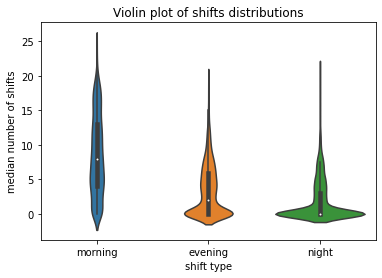

In [49]:
#create a violin plot
temp = pd.concat([pd.DataFrame({'median number of shifts':shifts_patient['median_mornings_in_month'], 'shift type': 'morning'}),
                  pd.DataFrame({'median number of shifts':shifts_patient['median_evenings_in_month'], 'shift type': 'evening'}),
                  pd.DataFrame({'median number of shifts':shifts_patient['median_nights_in_month'], 'shift type': 'night'}),
                 ])
sns.violinplot(data=temp, y='median number of shifts', x='shift type')
plt.title('Violin plot of shifts distributions')

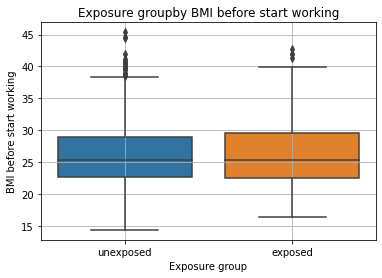

In [50]:
create_boxplot(df, 'expose_group', 'BMI_value_before_start_work', 'Exposure group', 'BMI before start working')

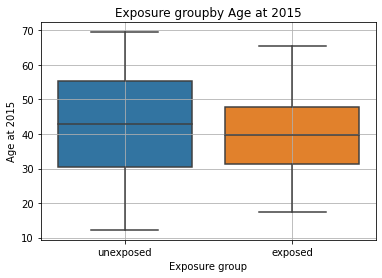

In [51]:
create_boxplot(df, 'expose_group', 'age_2015', 'Exposure group', 'Age at 2015')

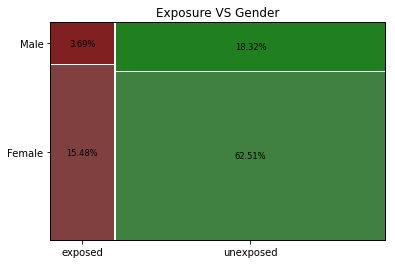

In [52]:
create_mosaic_plot(df, 'expose_group', 'Gender', x_col_name='Exposure')

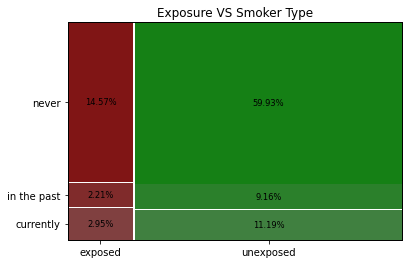

In [53]:
create_mosaic_plot(df, 'expose_group', 'max_smoke_prior_diagnose_value_eng', x_col_name='Exposure', y_col_name='Smoker Type')

### Health Records Plots

Analyse the differences in the covariates between patients diagnosed with GERD and ones that were not diagnosed

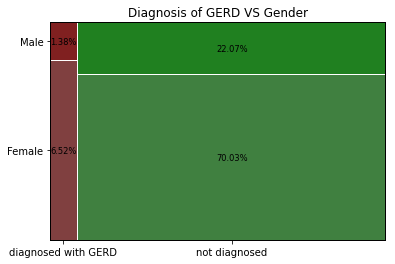

In [54]:
create_mosaic_plot(df, 'is_ill_cat', 'Gender', x_col_name='Diagnosis of GERD')

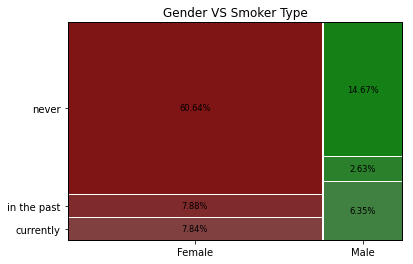

In [55]:
create_mosaic_plot(df, 'Gender', 'max_smoke_prior_diagnose_value_eng', x_col_name='Gender', y_col_name = 'Smoker Type')

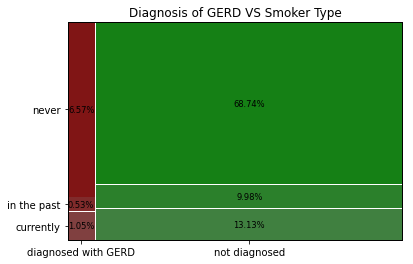

In [56]:
create_mosaic_plot(df, 'is_ill_cat', 'max_smoke_prior_diagnose_value_eng', x_col_name='Diagnosis of GERD', y_col_name = 'Smoker Type')

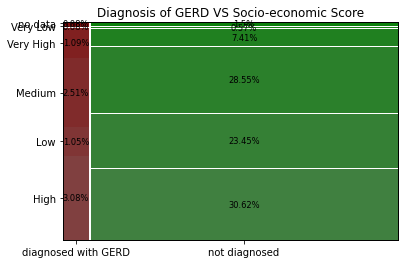

In [57]:
df['Socioeconomic score five level scale cat'] = df['Socioeconomic score five level scale'].astype('category')
create_mosaic_plot(df, 'is_ill_cat', 'Socioeconomic score five level scale cat', x_col_name='Diagnosis of GERD', y_col_name = 'Socio-economic Score')

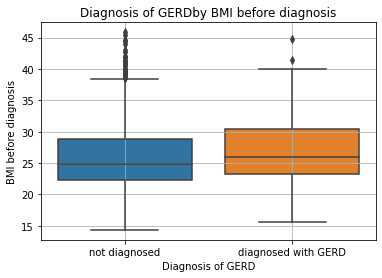

In [58]:
create_boxplot(df, 'is_ill_cat', 'BMI value before diag', 'Diagnosis of GERD', 'BMI before diagnosis')

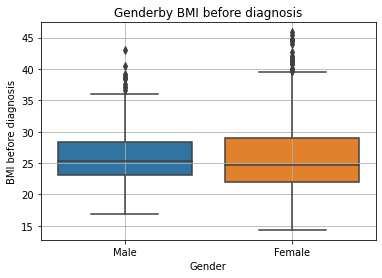

In [59]:
create_boxplot(df, 'Gender', 'BMI value before diag', 'Gender', 'BMI before diagnosis')

In [60]:
df.groupby('is_ill_cat').median()['BMI_value_before_start_work']

is_ill_cat
diagnosed with GERD    26.5731
not diagnosed          24.9770
Name: BMI_value_before_start_work, dtype: float64

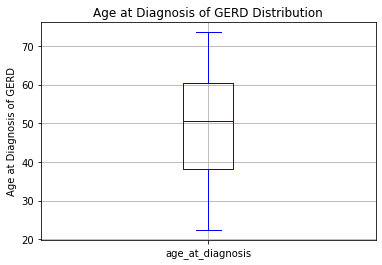

In [61]:
create_boxplot(df, None, 'age_at_diagnosis', None, 'Age at Diagnosis of GERD', False)

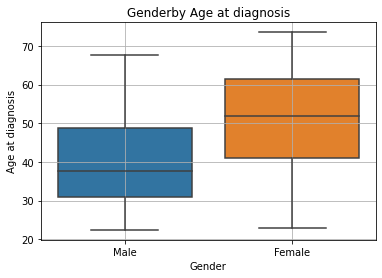

In [62]:
create_boxplot(df, 'Gender', 'age_at_diagnosis', 'Gender', 'Age at diagnosis')

In [63]:
df.groupby('Gender').median()['age_at_diagnosis']

Gender
Female    51.803010
Male      37.638076
Name: age_at_diagnosis, dtype: float64

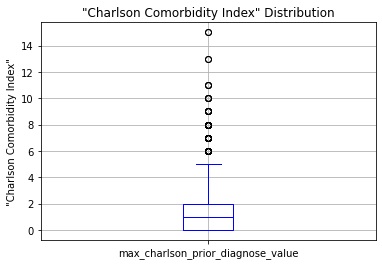

In [64]:
create_boxplot(df, None, 'max_charlson_prior_diagnose_value', None, '"Charlson Comorbidity Index"', False)

In [65]:
df['max_charlson_prior_diagnose_value'].median()

1.0

Text(0.5, 0, 'Socio-Economic Score')

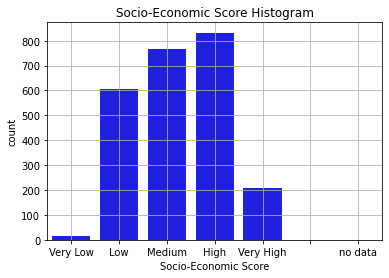

In [66]:
df['Socioeconomic score five level scale cat'] = df['Socioeconomic score five level scale'].astype('category')
temp = df[df['Socioeconomic score five level scale int']>-1]
sns.countplot(data=temp, x='Socioeconomic score five level scale cat', order=order_5.keys(), color='b')
plt.grid(True)
plt.title("Socio-Economic Score Histogram")
plt.xlabel('Socio-Economic Score')

## Statistical tests between diagnosis / exposure and variables

In [67]:
def perform_shapiru_mann_whitney(x_col, y_col, x_values):
    print("Statistical tests for: ", y_col, "and", x_col)
    statistic, p_value = shapiro(df[y_col].astype('float').dropna())
    print("Shapiro-Wilk test statistic:", statistic, "p-value:", p_value)

    x = np.array(df[df[x_col]==x_values[0]][y_col].astype('float').dropna())
    y = np.array(df[df[x_col]==x_values[1]][y_col].astype('float').dropna())
    statistic, p_value = mannwhitneyu(x=x, y=y)
    print("Mann Whitney U test statistic:", statistic, "p-value:", p_value)

In [68]:
# Perform the Shapiro-Wilk test for BMI before start of work
perform_shapiru_mann_whitney('expose_group', 'BMI_value_before_start_work', ['unexposed', 'exposed'])

Statistical tests for:  BMI_value_before_start_work and expose_group
Shapiro-Wilk test statistic: 0.9652376770973206 p-value: 6.0408830308771935e-24
Mann Whitney U test statistic: 237296.5 p-value: 0.6750092463895025


In [69]:
# Perform the Shapiro-Wilk test for BMI before diagnosis of GERD 
perform_shapiru_mann_whitney('is_ill', 'BMI value before diag', [False, True])

Statistical tests for:  BMI value before diag and is_ill
Shapiro-Wilk test statistic: 0.9640001058578491 p-value: 8.104197637858874e-24
Mann Whitney U test statistic: 145043.0 p-value: 0.004837395434921555


In [70]:
#compare means of BMI before diagnosis
a = df[df['is_ill']==False]['BMI value before diag'].mean()
b = df[df['is_ill']==True]['BMI value before diag'].mean()
a, b, a-b

(25.721438597285122, 26.913728947368416, -1.1922903500832938)

In [71]:
# Perform the Shapiro-Wilk test for age at diagnosis and shift work
perform_shapiru_mann_whitney('expose_group', 'age_at_diagnosis', ['unexposed', 'exposed'])

Statistical tests for:  age_at_diagnosis and expose_group
Shapiro-Wilk test statistic: 0.9626156687736511 p-value: 4.8341782530769706e-05
Mann Whitney U test statistic: 1599.0 p-value: 0.252040624752604


In [72]:
# Perform the Shapiro-Wilk test for age at 2015 and shift work
perform_shapiru_mann_whitney('expose_group', 'age_2015', ['unexposed', 'exposed'])

Statistical tests for:  age_2015 and expose_group
Shapiro-Wilk test statistic: 0.9646973013877869 p-value: 4.0456139878580675e-24
Mann Whitney U test statistic: 263814.0 p-value: 0.006294451650132076


In [73]:
a = df[df['expose_group']=='unexposed']['age_2015'].mean()
b = df[df['expose_group']=='exposed']['age_2015'].mean()
a, b, a-b

(42.67795041256108, 40.48775228985976, 2.190198122701318)